# Identifying SRKW Orca Calls using CNN and SNN
## 01-Generate Spectrograms

 Import Libraries

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import wavfile
import math
import random
import glob
import time
import gc
import json
import multiprocessing
from joblib import Parallel, delayed

 Define directions

In [2]:
parentdir="../"
codedir=parentdir+"code/"
datadir=parentdir+"data/"
train_dir=datadir+"TrainDataLatest_PodCastAllRounds_123567910/"
test_dir=datadir+"TestDataLatest_PodCastAllRounds_123/"
output=parentdir+"output/"
specdir=output+"spectrogram/"
specdir_train=specdir+"train/all/"
specdir_test=specdir+"test/all/"

specpaths=[specdir, specdir_train, specdir_test]
for i in range(len(specpaths)):
    if not os.path.exists(specpaths[i]):
        os.makedirs(specpaths[i])

 Loading labels for training and testing data

In [3]:
f=os.path.join(train_dir,'annotations.tsv')
anno_table=pd.read_csv(f, sep='\t')
del(f)

f=os.path.join(test_dir,'test.tsv')
test_table=pd.read_csv(f, sep='\t')
del(f)

Clean up typos and inconsistences in 'location' column

In [4]:
anno_table['location']=np.where(anno_table['location']=="Saanich Inlet, Victoria, VAncouver Island, British Columbia, Canada", 
    "Saanich Inlet, Victoria, Vancouver Island, British Columbia, Canada", 
    np.where(anno_table['location']=="80 mi. south of Martha's Vineyard, Massachusetts    X", 
        "80 mi. south of Martha's Vineyard, Massachusetts", 
        np.where(anno_table['location'].isin(['Oregon Coastal Aquarium, Newport, OR    X', 'Oregon Coast Aquarium']),
        'Oregon Coastal Aquarium, Newport, OR', anno_table['location'])))

 Create a list of wav file names from the existing files of both training and test data

In [5]:
train_audiolist=set(os.listdir(train_dir+"wav/"))
train_audiolist=[i for i in train_audiolist if i.endswith('.wav') and not i.startswith('._')]

test_audiolist=list(set(os.listdir(test_dir+"wav/")))
test_audiolist=[i for i in test_audiolist if i.endswith('.wav') and not i.startswith('._')]

 Create a function to read in wav and return sample rate, data, and file length

In [6]:
def readinwav(wav_file):
    rate, audio=wavfile.read(wav_file)
    wavdur=audio.shape[0]/rate
    return rate, wavdur, audio

Helper function to split samples into desired length and generate spectrogram

In [7]:
def make_spectro(i, train=True, showplt=False):

    if train==True:
        wav_filename=anno_table.iloc[i, 1]
        start_time_s=anno_table.iloc[i, 2]
        duration_s=anno_table.iloc[i, 3]
        location=anno_table.iloc[i, 4]
        date=anno_table.iloc[i, 5]
        audiodump=readinwav(os.path.join(train_dir,"wav",wav_filename))
        folder=specdir_train
    else:
        wav_filename=test_table.iloc[i, 1]
        start_time_s=test_table.iloc[i, 2]
        duration_s=test_table.iloc[i, 3]
        location=test_table.iloc[i, 4]
        date=test_table.iloc[i, 5]
        audiodump=readinwav(os.path.join(test_dir,"wav",wav_filename))
        folder=specdir_test
    #Define labels for positive and negative entries
    if duration_s==0:
        sig='neg'
    else:
        sig='pos'

    # Get sample rate, wav duration, and audio data 
    rate=audiodump[0]
    dur=audiodump[1]
    audiodat=audiodump[2]

    #Convert to mono channel if stereo 
    if audiodat.ndim==2:
        audiodat = np.mean(audiodat, axis=1)

    # Calculate end time
    # For positive samples: end time=start time + duration 
    # For negative samples, end time is a random number that 
    # is within the bound of the audio length
    if duration_s!=0:
        if start_time_s+duration_s<=dur:
            end_time_s=start_time_s+duration_s
        else: 
            end_time_s=dur
    else:
        end_time_s=dur*random.random()
    # draw spectrogram
    audiocut=audiodat[math.floor(rate*start_time_s):math.ceil(rate*end_time_s)] 
    #plt.figure(figsize=(19,12))
    plt.subplot(222)
    ax=plt.axes()    
    ax.set_axis_off()
    plt.specgram(audiocut,
        Fs=rate, 
        NFFT=1024, 
        noverlap=int(1024*0.75))       
    plt.savefig(folder+wav_filename.split(".")[0]+"_"+str(int(start_time_s))+"_"+sig+".png", \
        bbox_inches="tight", transparent=True, pad_inches=0.0)

    if showplt==True:
        plt.show()
    plt.close()
    gc.collect()
    return wav_filename, location, date, rate, dur, duration_s, start_time_s, end_time_s

 Example of spectrograms

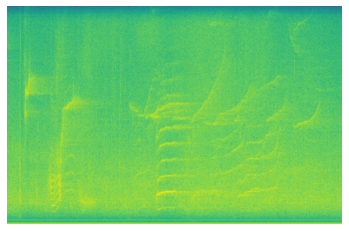

File name: 89405023.wav; Location: Andenes, Norway; Date: 1989-09-09; Sampel Rate: 20000; Audio length: 14.2495; Sample duration: 14.249; Start time: 0.0; End time: 14.249


In [21]:
x=make_spectro(614, train=True, showplt=True)
print(f'File name: {x[0]}; Location: {x[1]}; Date: {x[2]}; Sampel Rate: {x[3]}; Audio length: {x[4]}; Sample duration: {x[5]}; Start time: {x[6]}; End time: {x[7]}')

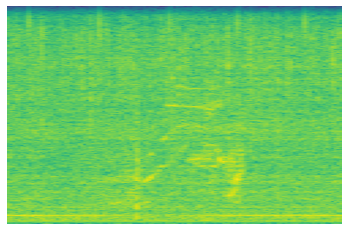

File name: OS_9_27_2017_09_02_00__0002.wav; Location: orcasound_lab; Date: 9/27/2017; Sampel Rate: 20000; Audio length: 61.25; Sample duration: 1.6163194440000002; Start time: 55.72048611; End time: 57.336805554


In [22]:
x=make_spectro(615, train=False, showplt=True)
print(f'File name: {x[0]}; Location: {x[1]}; Date: {x[2]}; Sampel Rate: {x[3]}; Audio length: {x[4]}; Sample duration: {x[5]}; Start time: {x[6]}; End time: {x[7]}')

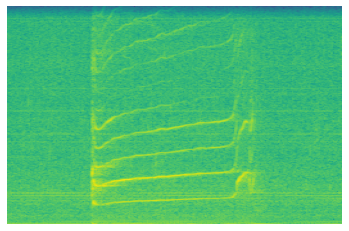

File name: 9761900A.wav; Location: Oregon Coastal Aquarium, Newport, OR; Date: 1997-02-21; Sampel Rate: 20000; Audio length: 3.3827; Sample duration: 3.382; Start time: 0.0; End time: 3.382


In [23]:
x=make_spectro(1515, train=True, showplt=True)
print(f'File name: {x[0]}; Location: {x[1]}; Date: {x[2]}; Sampel Rate: {x[3]}; Audio length: {x[4]}; Sample duration: {x[5]}; Start time: {x[6]}; End time: {x[7]}')

 Draw spectrogram and then save audio data to a dictionary

In [24]:
tic=time.time()
num_cores = multiprocessing.cpu_count()
res=Parallel(n_jobs=num_cores)(delayed(make_spectro)(i) for i in range(anno_table.shape[0]))
toc=time.time()
print(f"Elapsed time: {round(toc-tic,2)} s")

Elapsed time: 3178.55 s


In [8]:
# to run make spectro for individual files
for i in [151,260,283,299,301,3154]:
    make_spectro(i, train=True)

Draw spectrogram for testing data

In [ ]:
for i in range(test_table.shape[0]):
    make_spectro(i, train=False)

 Save the audio entry data into a json file for later use

In [ ]:
import json
audiodump=dict()
for i in range(len(res)):
    audiodump[str(i)]=res[i]
del(i)
with open(output+'audiodump_train.json', 'w') as fp:
    json.dump(audiodump, fp,  indent=4)